# КР2
В данном ноутбуке я реализовала метод CAMNS-LP для blind source separation покомпонетно неотрицательных источников.

Ссылка на [оригинальную статью](https://www.researchgate.net/profile/Chong-Yung-Chi/publication/251134144_A_Convex_Analysis_Framework_for_Blind_Separation_of_NonNegative_Sources/links/5a1e7622aca272cbfbc04995/A-Convex-Analysis-Framework-for-Blind-Separation-of-NonNegative-Sources.pdf?_sg%5B0%5D=OMb8GSQ1miraTnwj9MuTl_sWqMTmx1MXLO3B6zfVi4OFqD1thTV7qA1ojzXKQSucagGKOYVy8QmNQOoE5oLX7Q.HcFDAcJ9Gd4ltbvqp_7ndt1Yhg35PL0PJa3iOnYJcpBA3OIiuYwL72YJ6ry46Cb_NEHNsAZBgi3jpf8EMTzYEg.b9vSGHXLraOewNOZkrAVlPI3Gdpmzc9JO-KbP2hbAA1PmpKU1T0TtgFylKVSCgVhmm7gCmd1kar37FwL4MKtKQ&_sg%5B1%5D=WIdyA5iABGfzLmDfwEfigkwWoN-Ahwrw8Z3t4D_7wZLt5iAIKaiCWZQYsLGAFMr59D7yASkWgn4KQy0-4-DErwnDWhtnvybd10KIsKCKc3BT.HcFDAcJ9Gd4ltbvqp_7ndt1Yhg35PL0PJa3iOnYJcpBA3OIiuYwL72YJ6ry46Cb_NEHNsAZBgi3jpf8EMTzYEg.b9vSGHXLraOewNOZkrAVlPI3Gdpmzc9JO-KbP2hbAA1PmpKU1T0TtgFylKVSCgVhmm7gCmd1kar37FwL4MKtKQ&_iepl=)

Решаем задачу восстановления источников по наблюдениям из их перемешанных сигналов.

Требования на даныне налагаются следюущие:
1. Вектора входных источников покомпонентно неотрицательные
2. Наблюдений должно быть не меньше, чем оригинальных источников
3. Для каждого наблюдения должен быть источник, сигнал которого внес наибольший вклад в это наблюдение. Это требование нужно для того, чтобы всегда нашлось экстремальное значение
4. Перемешивание источников осуществляется как $X = AS$, при этом $\forall j \sum\limits_{i=1}^N a_{ij} = 1$.
5. Матрица A как раз должна обеспечивать превосходство одного из источников в каждом наблюдении, но это не то чтобы сильно обязательно (дальше есть комментарий на этот счет).

Из возможных оптимизаций можно выделить идею о каком-то неслучайном подборе $w$, который используется в алгоритме. Сходимость и так достаточно быстрая, но и картинки не очень-то большие. Более детерминированный подход должен увеличить скорость сходимости.

Еще, возможно, стоит придумать какие-то вычислительные методы, чтобы не хранить полные матрицы, потому что на больших изображениях не хватает памяти, а значит страдает практичность алгоритма.

In [1]:
import numpy as np
import scipy.stats as sps
import cvxpy as cvx
import matplotlib.pyplot as plt

class CAMNS_LP:
    def __init__(self, tol_lp=1e-3, tol_ext=1e-6):
        """
        Create CAMNS_LP blind separator.
        
        Args:
        - tol_lp: default is 1e-3
        - tol_ext: default is 1e-6
        
        Returns:
        - CAMNS_LP separator object
        """
        
        self.tol_lp = tol_lp
        self.tol_ext = tol_ext
    
    def __is_extreme(self, alpha):
        """
        Checks if point is extreme.
        
        Args:
        - alpha: point vector
        
        Returns:
        - bool: True if point is extreme, False if it is not
        """
        
        L, D = self.C.shape
        T = self.C[np.all(np.abs(np.expand_dims(self.C.dot(alpha) + self.d, axis=1)) < self.tol_ext, axis=1), :]
        if not T.shape[0]:
            return False
        return np.linalg.matrix_rank(T) == D
    
    def __convexify(self, X, N):
        """
        Convexifies blind source separation task.
        
        Args:
        - X: matrix of observations
        - N: number of observations
        
        Returns:
        - None
        """
        
        self.d =  np.mean(X, axis=1)
        self.C = np.linalg.svd(X - np.expand_dims(self.d, axis=1), full_matrices=False)[0][:, :N-1]
    
    def __init_separation(self):
        """
        Initalizes separation routine.
        
        Args:
        - None
        
        Returns:
        - None
        """
        
        self.l = 0
        self.S = np.zeros(shape=(0, self.L))
        self.B = np.diag(np.ones(self.L))
        
    def __convex_optimize(self, r, minimize=True):
        """
        Performs convex optimization.
        
        Args:
        - r: vector
        
        Returns:
        - alpha: argmin value
        - result: convex problem solution
        """
        
        alpha = cvx.Variable(self.C.shape[1])
        prob = None
        
        if minimize:
            prob = cvx.Problem(cvx.Minimize(r.T @ (self.C @ alpha + self.d)), [self.C @ alpha + self.d >= 0])
        else:
            prob = cvx.Problem(cvx.Maximize(r.T @ (self.C @ alpha + self.d)), [self.C @ alpha + self.d >= 0])
        result = prob.solve()
        
        return (alpha.value, result)
    
    def __QR(self):
        """
        Performs QR decomposition if it is needed and updates the B matrix.
        
        Args:
        - None
        
        Returns:
        -None
        
        """
        
        if self.l > 0:
            Q = np.linalg.qr(self.S.T)[0]
            self.B = np.diag(np.ones(self.L)) - Q @ Q.T
    
    
    def __append_extreme(self, alpha):
        """
        Appends point to sources array if it is extreme.
        
        Args:
        - alpha: point vector
        
        Returns:
        - None
        """
        
        if self.__is_extreme(alpha):
            self.S = np.append(self.S, [(self.C @ alpha + self.d).squeeze()], axis=0)
    
    def __update(self, alpha_1, alpha_2, p_star, q_star, r):
        """
        Updates sources array depending on convex problem solution.
        
        Args:
        - alpha_1: minimization problem argmin
        - alpha_2: maximization problem argmax
        - p_star: minimization problem result
        - q_star: maxmimization problem result
        - r: vector
        
        Returns:
        - None
        """
        
        if self.l == 0:
            self.__append_extreme(alpha_1)
            self.__append_extreme(alpha_2)
        else:
          if p_star / (np.linalg.norm(r) * np.linalg.norm(self.C @ alpha_1 + self.d)) >= self.tol_lp:
            self.__append_extreme(alpha_1)
          if q_star / (np.linalg.norm(r) * np.linalg.norm(self.C @ alpha_2 + self.d)) >= self.tol_lp:
            self.__append_extreme(alpha_2)
    
    def __step(self):
        """
        Performs one separation step.
        
        Args:
        - None
        
        Returns:
        - None
        """
        
        w = sps.norm.rvs(size=self.L)
        r = self.B.dot(w)  
        alpha_1, p_star = self.__convex_optimize(r)
        alpha_2, q_star = self.__convex_optimize(r, minimize=False)
        self.__update(alpha_1, alpha_2, p_star, q_star, r)
        self.l = self.S.shape[0]
        self.__QR()
    
    def separate(self, X, N):
        """
        Perform signal separation.
        
        Args:
        - X: matrix of observations
        - N: number of observations
        
        Returns:
        - S: matrix of sources
        """
        
        self.L, self.M = X.shape
        self.__convexify(X, N)
        self.__init_separation()
        
        while self.l < N:
            self.__step()
        return self.S

Перейдем к демонстрации работы CAMNS. Представим, что мне отправили три картинки лам через наш горячо любимый МФТИ-телеком, но в процессе отправки роутеры сломались и все смешалось. Лам обещали очень красивых, поэтому я решила их разделить.

Вот таких лам мне отправили:

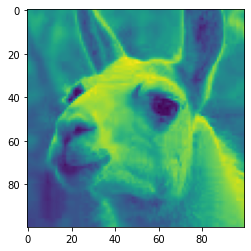

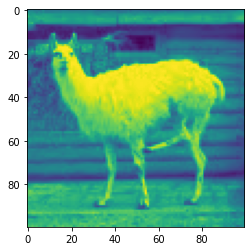

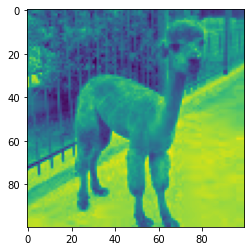

In [2]:
img1 = (plt.imread('images/lama.jpg').astype(np.float64)[:, :, 0] / 255.0).flatten()
img2 = (plt.imread('images/lama_white.jpg').astype(np.float64)[:, :, 0] / 255.0).flatten()
img3 = (plt.imread('images/lama_brown.jpg').astype(np.float64)[:, :, 0] / 255.0).flatten()

plt.imshow(img1.reshape(100, 100) * 255)
plt.show()
plt.imshow(img2.reshape(100, 100) * 255)
plt.show()
plt.imshow(img3.reshape(100, 100) * 255)
plt.show()

А вот что с ними сделал МФТИ-телеком((( Некоторые черты угадываются, но хочется-то оченить истинные масштабы красоты!

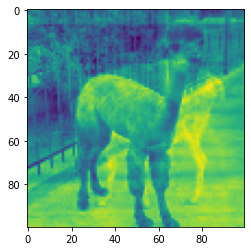

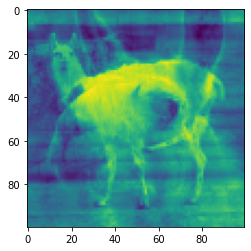

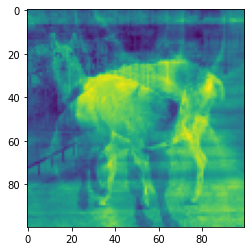

In [4]:
# Some of the assumptions from the paper are corrupted with
# that mixing matrix construction, however it is not critical
# since those assumptions are only needed to prove the correctness
# of the CAMNS_LP method.
src_mat = np.random.rand(3, 3)
mix_mat = src_mat / np.expand_dims(np.sum(src_mat, axis=1), axis=1)
imgs = np.array([img1, img2, img3])
mixed = mix_mat.dot(imgs)
plt.imshow(mixed[0].reshape(100, 100) * 255)
plt.show()
plt.imshow(mixed[1].reshape(100, 100) * 255)
plt.show()
plt.imshow(mixed[2].reshape(100, 100) * 255)
plt.show()

Я достаю CAMNS_LP из ширких штанин и voilà!

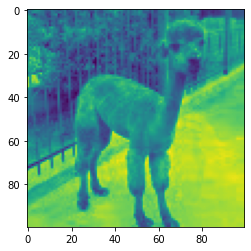

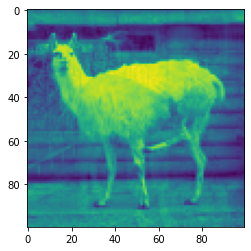

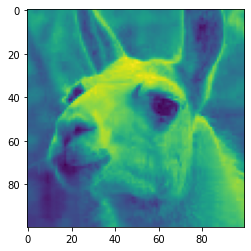

In [7]:
separator = CAMNS_LP()
raw_signal = separator.separate(mixed.T, 3)
plt.imshow(raw_signal[0].reshape(100, 100) * 255)
plt.show()
plt.imshow(raw_signal[1].reshape(100, 100) * 255)
plt.show()
plt.imshow(raw_signal[2].reshape(100, 100) * 255)
plt.show()

CAMNS_LP восстановил моих прекрасных ламочек, а значит офис МФТИ-телекома постоит еще денек в КПМе. Разделение прошло почти идеально, хотя остались некоторые вкрапления картинок друг в друга. В основном, разделение произошло не совсем идеально из-за того, что я не приняла во внимание условие про локальную доминантность одного из изначальных изображений в каждом смешанном. Для этого надо сконструировать матрицу каким-то неочевидным образом.

Тем не менее, в целом, результат работы алгоритма налицо, а значит все круто!